# Prepare Data

## Imports and Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from helper_code import *
from sklearn.preprocessing import StandardScaler
import time
import math
import seaborn as sns
from sklearn.model_selection import train_test_split

## Train Test Split
The dataset here only has the filenames of each recording, and the tf.Dataset object will load the recording itself during the training to make the training memory efficient

In [2]:
full_df = pd.read_csv("full_dataset.csv")
full_df

,Recording,Afib,Afl,MI,SVT,DB
0,data/cpsc/A4924.mat,0,0,0,0,CP
1,data/cpsc/A2054.mat,0,0,0,0,CP
2,data/cpsc/A5391.mat,0,0,0,0,CP
3,data/cpsc/A3580.mat,0,0,0,0,CP
4,data/cpsc/A4948.mat,0,0,0,0,CP
...,...,...,...,...,...,...
85738,data/ningbo/JS32861.mat,0,0,0,0,NI
85739,data/ningbo/JS41305.mat,0,0,0,0,NI
85740,data/ningbo/JS25189.mat,0,0,0,0,NI
85741,data/ningbo/JS42616.mat,0,0,0,0,NI


In [12]:
train_df, val_df = train_test_split(full_df, test_size=0.2, random_state=42)

In [13]:
# Ensure that the % of SVT is the same as the 20% train test split
print("% of SVT in test: {}".format(val_df['SVT'].sum()/full_df['SVT'].sum()))

% of SVT in test: 0.1941448382126348


## Visualize Data Augmentations
We increase the dataset with 3 augmentations:
1. Adding low freq sine wave as baseline wander
2. Adding 50Hz power line noise
3. Adding random gaussian noise

This is to make the model more robust to noise that might be present in real ECG data

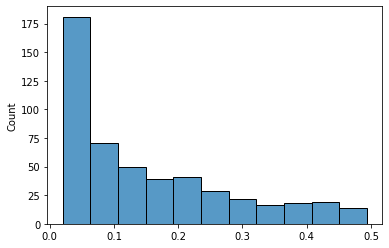

In [14]:
# Use loguniform so as to concentrate the randomness in the lower spectrum

from scipy.stats import loguniform

arr = []
for i in range(500):
    arr.append(loguniform.rvs(0.02, 0.5, size=None))
    
sns.histplot(data=arr)
plt.show()

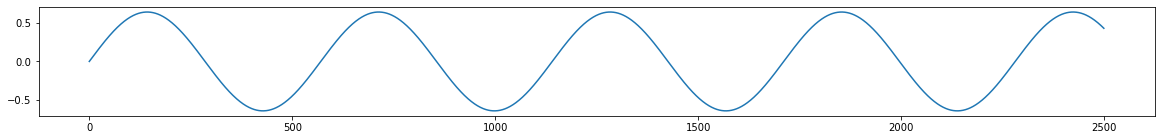

In [15]:
# Baseline Wander

def get_bw(qrs_amp):
    amp = np.random.rand() * 0.15 * qrs_amp      # Amplitude
    f = loguniform.rvs(0.02, 0.5, size=None)     # Frequency
    fs = 250                                     # Sample Rate
    t = 10

    x = np.arange(fs * t)
    y = [amp*np.sin(2 * np.pi * f * (i/fs)) for i in x]
    
    return np.array(y)

y = get_bw(6)

plt.figure(figsize=(20,2))
plt.plot(list(range(len(y))), y)

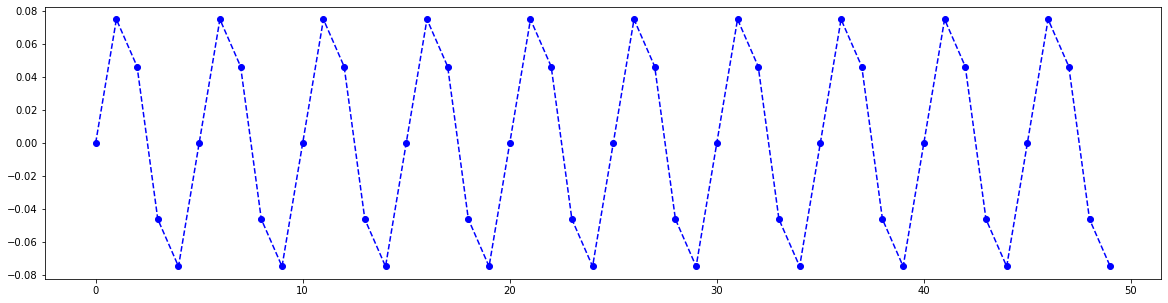

In [16]:
# Power Line

def get_pli(qrs_amp):
    amp = qrs_amp * 0.025 * np.random.rand()    # Amplitude
    f = 50     # Frequency
    fs = 250     # Sample Rate
    t = 10

    x = np.arange(fs * t)
    y = [amp*np.sin(2 * np.pi * f * (i/fs)) for i in x]
    
    return np.array(y)
    
y = get_pli(6.5)

plt.figure(figsize=(20,5))
plt.plot(list(range(len(y[:50]))), y[:50], '--bo')

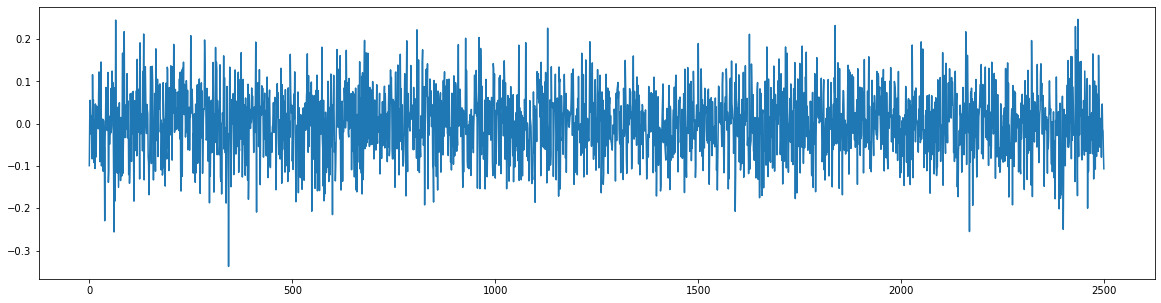

In [17]:
# Gaussian Noise

def get_gauss():
    gauss = np.random.normal(0, 0.08, (2500,))
    
    return gauss

gauss = get_gauss()

plt.figure(figsize=(20,5))
plt.plot(list(range(len(gauss))), gauss)

## Preprocess Signal

In [18]:
scaler = StandardScaler()
# filename = 'data/ptbxl/HR08056.mat' # normal
filename = 'data/chapman/JS06976.mat' # Afl

recording = load_recording(filename)
recording = recording.astype(np.float32).T
recording = recording[0:5000:2] # resample to 250Hz
print(recording.T.shape)
recording = scaler.fit_transform(recording) # Normalize

lead = recording.T

(12, 2500)


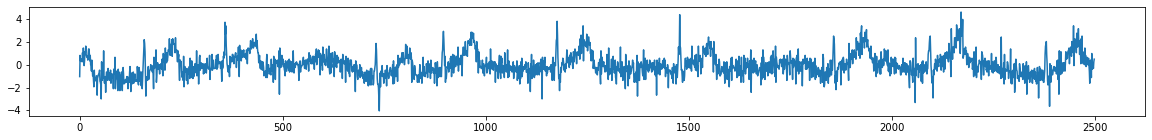

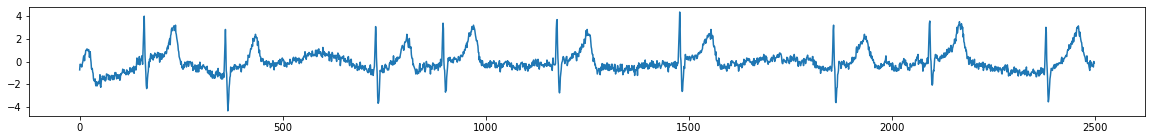

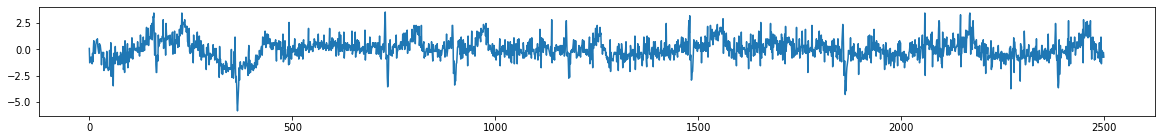

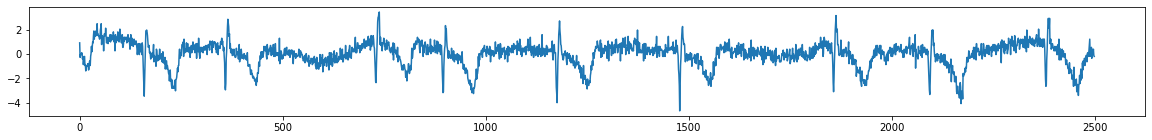

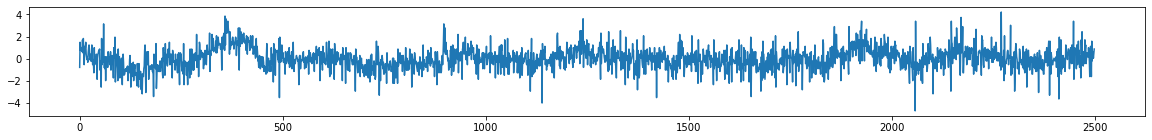

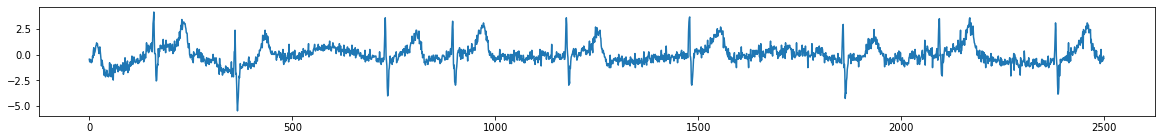

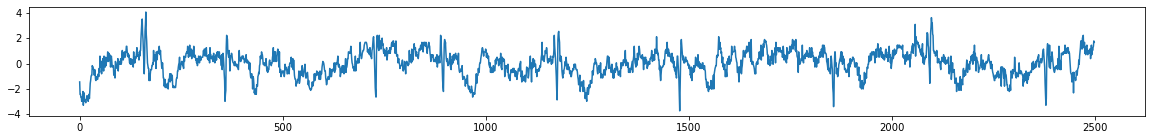

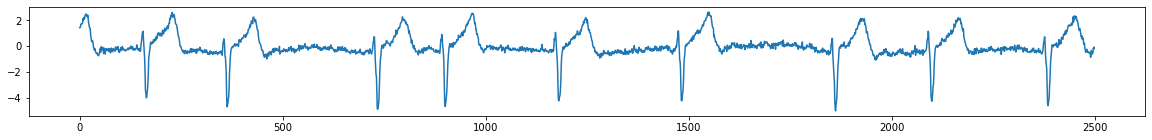

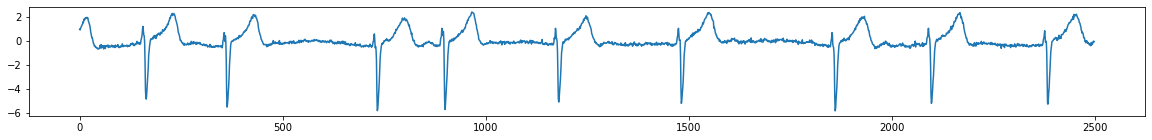

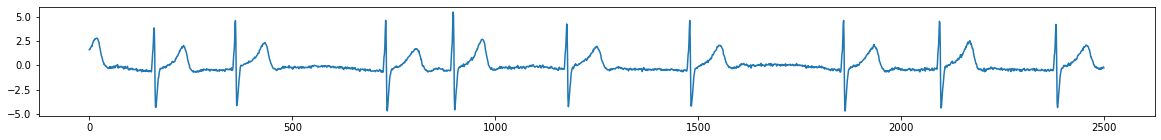

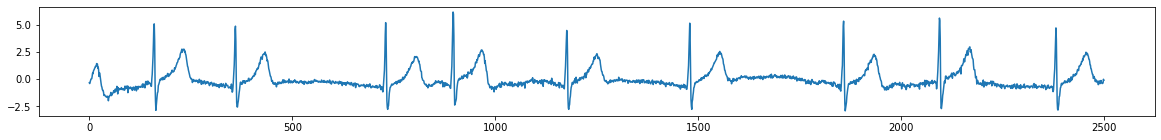

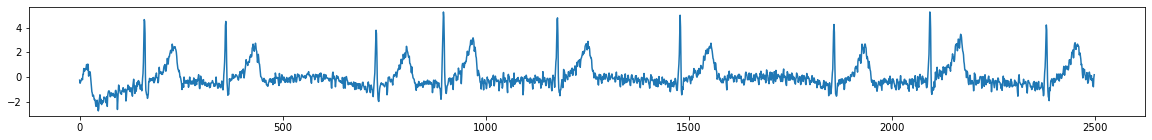

In [19]:
# visualisation of leads without augmentation

for i in range(12):
    plt.figure(figsize=(20,2))
    plt.plot(list(range(len(lead[i]))), lead[i])

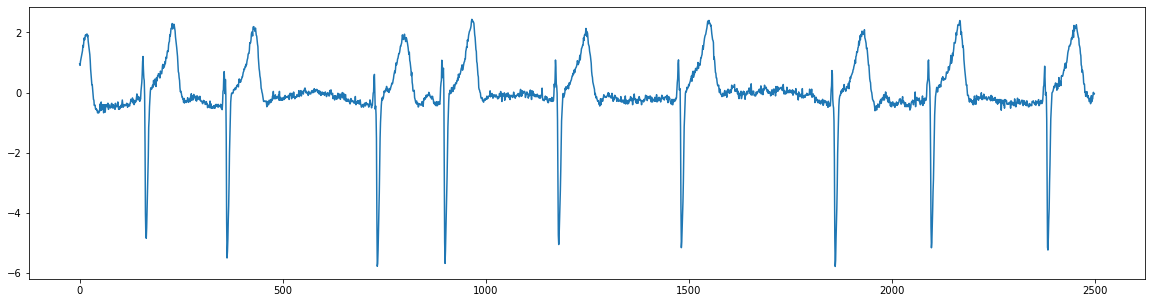

In [20]:
# visualisation of lead with baseline wander
lead_1 = lead[8] + get_bw(6)

plt.figure(figsize=(20,5))
plt.plot(list(range(len(lead_1))), lead_1)

In [21]:
def augment_leads(leads, aug_no):
    new_leads = []
    
    for lead in leads:
        qrs_amp = max(lead.max(), abs(lead.min()))
        
        if aug_no == 2:
            lead = lead + get_bw(qrs_amp)
        elif aug_no == 3:
            lead = lead + get_pli(qrs_amp)
        elif aug_no == 4:
            lead = lead + get_gauss()
        
        new_leads.append(lead)
    
    return np.array(new_leads)

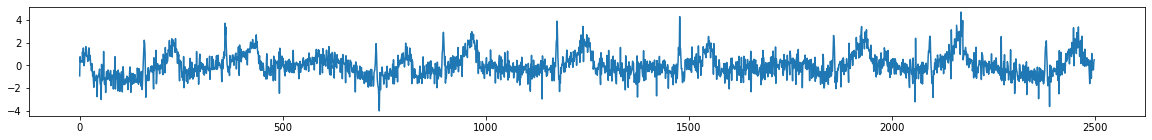

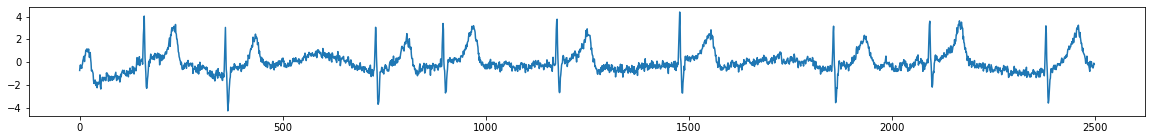

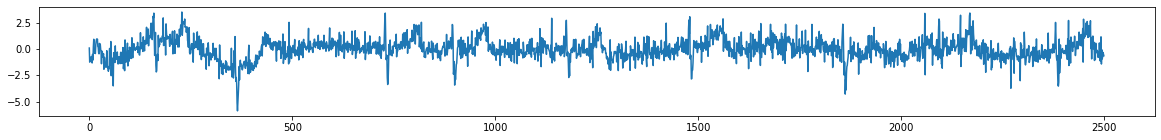

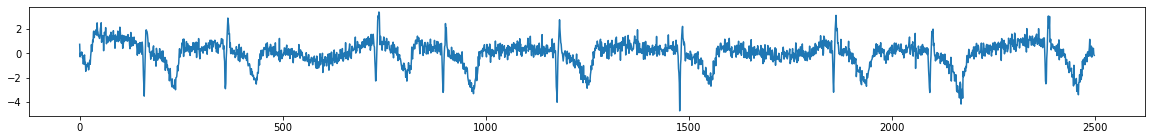

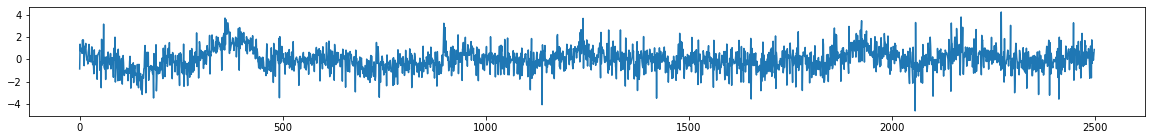

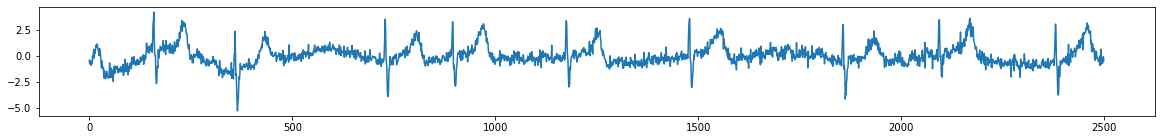

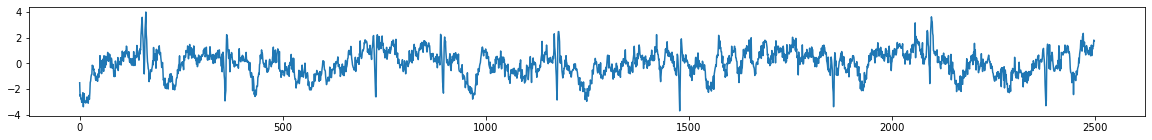

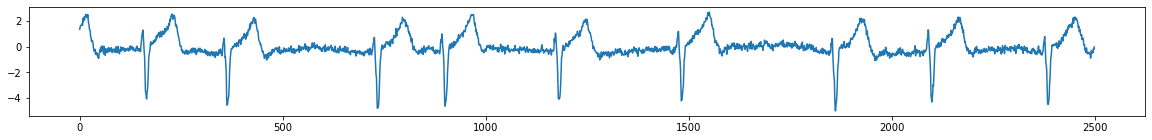

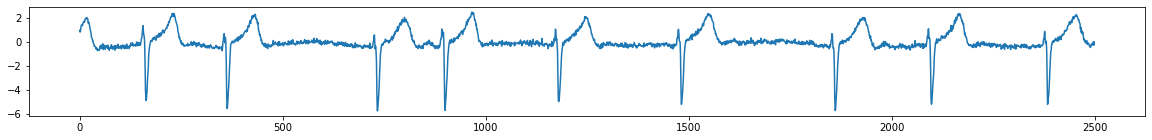

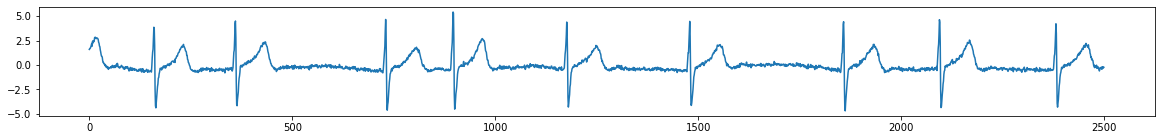

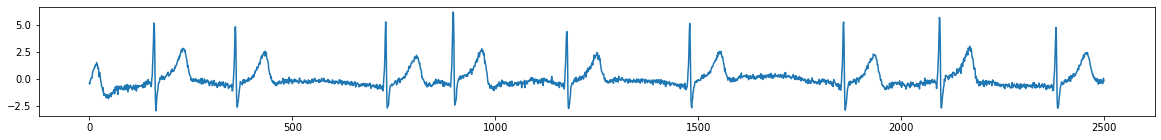

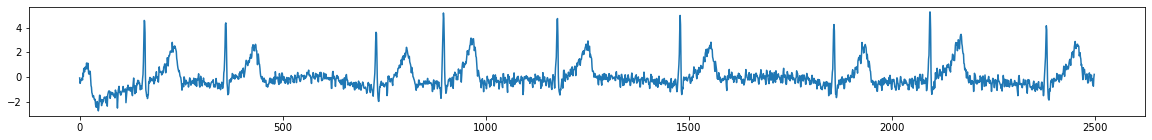

In [23]:
# visualisation of leads with augmentation

lead = augment_leads(lead, 4)

for i in range(12):
    plt.figure(figsize=(20,2))
    plt.plot(list(range(len(lead[i]))), lead[i])

In [24]:
channels = []
channels.append(np.concatenate((lead[0][:625], lead[3][625:1250], lead[6][1250:1875], lead[9][1875:])))
channels.append(np.concatenate((lead[1][:625], lead[4][625:1250], lead[7][1250:1875], lead[10][1875:])))
channels.append(np.concatenate((lead[2][:625], lead[5][625:1250], lead[8][1250:1875], lead[11][1875:])))
channels.append(lead[1])

channels = np.array(channels)

In [25]:
channels.shape

(4, 2500)

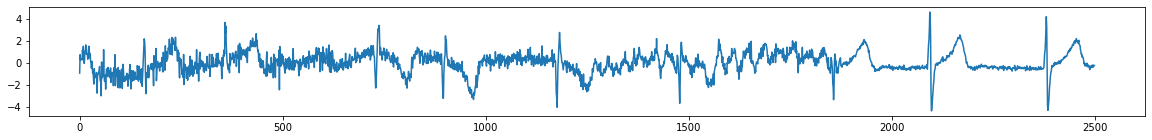

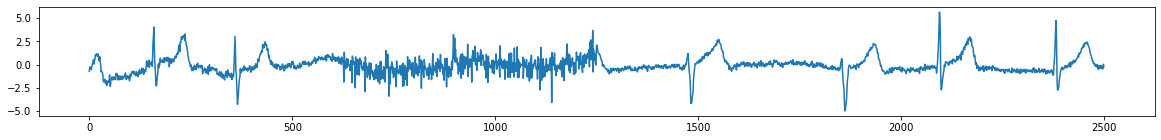

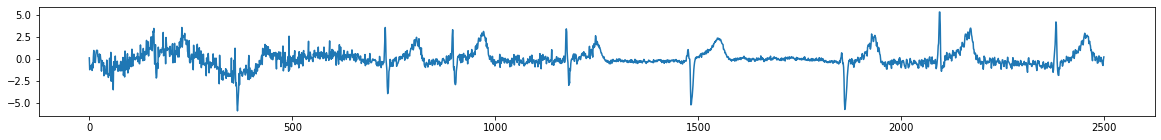

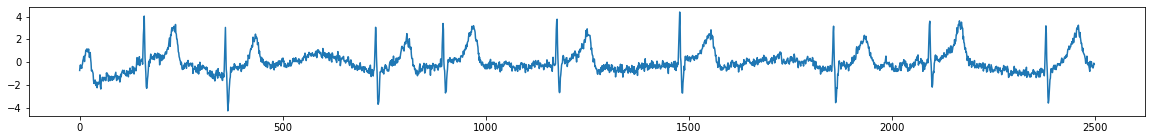

In [26]:
# final input to CNN (ecg with 12 leads but 4 channels)

for i in range(4):
    plt.figure(figsize=(20,2))
    plt.plot(list(range(len(channels[i]))), channels[i])

# Model for SVT

## Prepare SVT Data

In [27]:
svt_train = train_df[['Recording', 'SVT']]
svt_train

,Recording,SVT
44120,data/chapman/JS06381.mat,0
20549,data/ptbxl/HR15210.mat,0
48551,data/chapman/JS07050.mat,0
28465,data/ptbxl/HR09754.mat,0
39538,data/ptbxl/HR17312.mat,0
...,...,...
11284,data/georgia/E06260.mat,0
44732,data/chapman/JS09050.mat,0
38158,data/ptbxl/HR13585.mat,0
860,data/cpsc/A5399.mat,0


In [28]:
svt_train_F = svt_train[svt_train['SVT'] == 0]
svt_train_F

,Recording,SVT
44120,data/chapman/JS06381.mat,0
20549,data/ptbxl/HR15210.mat,0
48551,data/chapman/JS07050.mat,0
28465,data/ptbxl/HR09754.mat,0
39538,data/ptbxl/HR17312.mat,0
...,...,...
11284,data/georgia/E06260.mat,0
44732,data/chapman/JS09050.mat,0
38158,data/ptbxl/HR13585.mat,0
860,data/cpsc/A5399.mat,0


In [29]:
svt_train_T = svt_train[svt_train['SVT'] == 1]
svt_train_T

,Recording,SVT
50752,data/chapman/JS10510.mat,1
49420,data/chapman/JS10100.mat,1
49324,data/chapman/JS10206.mat,1
43982,data/chapman/JS09927.mat,1
49795,data/chapman/JS10404.mat,1
...,...,...
44215,data/chapman/JS09965.mat,1
45151,data/chapman/JS10435.mat,1
11653,data/georgia/E03511.mat,1
44974,data/chapman/JS09962.mat,1


In [30]:
# increase positive afl examples to reduce class imbalance
for i in range(59):
    svt_train_T = pd.concat([svt_train_T, svt_train[svt_train['SVT'] == 1]], ignore_index=True)
svt_train_T

,Recording,SVT
0,data/chapman/JS10510.mat,1
1,data/chapman/JS10100.mat,1
2,data/chapman/JS10206.mat,1
3,data/chapman/JS09927.mat,1
4,data/chapman/JS10404.mat,1
...,...,...
31375,data/chapman/JS09965.mat,1
31376,data/chapman/JS10435.mat,1
31377,data/georgia/E03511.mat,1
31378,data/chapman/JS09962.mat,1


In [33]:
svt_train = pd.concat([svt_train_T, svt_train_F], ignore_index=True)
svt_train = svt_train.sample(frac=1).reset_index(drop=True)
svt_train

,Recording,SVT
0,data/chapman/JS10469.mat,1
1,data/chapman/JS08183.mat,0
2,data/chapman/JS10572.mat,1
3,data/chapman/JS10563.mat,1
4,data/chapman/JS09951.mat,1
...,...,...
71522,data/georgia/E00577.mat,0
71523,data/chapman/JS10147.mat,1
71524,data/ptbxl/HR02448.mat,0
71525,data/chapman/JS10519.mat,1


In [34]:
x_train = np.array(svt_train['Recording'])
x_train

array(['data/chapman/JS10469.mat', 'data/chapman/JS08183.mat',
       'data/chapman/JS10572.mat', ..., 'data/ptbxl/HR02448.mat',
       'data/chapman/JS10519.mat', 'data/chapman/JS10193.mat'],
      dtype=object)

In [35]:
y_train = np.array(svt_train[['SVT']])
y_train.shape

(71527, 1)

In [36]:
x_val = np.array(val_df['Recording'])
x_val

array(['data/ptbxl/HR18378.mat', 'data/georgia/E01376.mat',
       'data/ptbxl/HR18913.mat', ..., 'data/georgia/E00944.mat',
       'data/ptbxl/HR18203.mat', 'data/georgia/E09552.mat'], dtype=object)

In [37]:
y_val = np.array(val_df[['SVT']])
y_val.shape

(10168, 1)

## Dataset Prep

Use tf.data.Dateset as a data loader for training

In [39]:
import tensorflow as tf
print(tf.__version__)

2.4.2


In [39]:
scaler = StandardScaler()

In [40]:
def get_ecg(filename, label):
    def process_mat(filename):
        recording = load_recording(filename)
        recording = recording.astype(np.float32).T
        recording = recording[0:5000:2] # resample to 250Hz
        recording = scaler.fit_transform(recording) # Normalize
        lead = recording.T
        
        # Random number from 1 to 6. 
        # 2, 3, 4 will have augmentations, 1, 5, 6, will be original
        lead = augment_leads(lead, np.random.randint(1, 7))
        
        channels = []
        channels.append(np.concatenate((lead[0][:625], lead[3][625:1250], lead[6][1250:1875], lead[9][1875:])))
        channels.append(np.concatenate((lead[1][:625], lead[4][625:1250], lead[7][1250:1875], lead[10][1875:])))
        channels.append(np.concatenate((lead[2][:625], lead[5][625:1250], lead[8][1250:1875], lead[11][1875:])))
        channels.append(lead[1])
        channels = np.array(channels)
        
        return channels.astype(np.float32).T
        
    recording = tf.numpy_function(process_mat, [filename], [tf.float32])
    recording = tf.reshape(recording, (2500, 4))

    return recording, label

In [41]:
def get_val(filename, label):
    def process_mat(filename):
        recording = load_recording(filename)
        recording = recording.astype(np.float32).T
        recording = recording[0:5000:2] # resample to 250Hz
        recording = scaler.fit_transform(recording) # Normalize
        lead = recording.T
        
        channels = []
        channels.append(np.concatenate((lead[0][:625], lead[3][625:1250], lead[6][1250:1875], lead[9][1875:])))
        channels.append(np.concatenate((lead[1][:625], lead[4][625:1250], lead[7][1250:1875], lead[10][1875:])))
        channels.append(np.concatenate((lead[2][:625], lead[5][625:1250], lead[8][1250:1875], lead[11][1875:])))
        channels.append(lead[1])
        channels = np.array(channels)
        
        return channels.T
        
    recording = tf.numpy_function(process_mat, [filename], [tf.float32])
    recording = tf.reshape(recording, (2500, 4))

    return recording, label

In [42]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(get_ecg)
train_dataset = train_dataset.shuffle(5000)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(64, drop_remainder=True)

In [43]:
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.map(get_val)
val_dataset = val_dataset.repeat()
val_dataset = val_dataset.batch(64, drop_remainder=True)

In [44]:
train_dataset, val_dataset

(<BatchDataset shapes: ((64, 2500, 4), (64, 1)), types: (tf.float32, tf.int64)>,
 <BatchDataset shapes: ((64, 2500, 4), (64, 1)), types: (tf.float32, tf.int64)>)

## Model Building and Training

In [45]:
from tensorflow.keras.layers import Input, Dense, Conv1D, BatchNormalization, AveragePooling1D
from tensorflow.keras.layers import ReLU, Add, MaxPool1D, GlobalAvgPool1D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

In [47]:
def Conv_BatchNorm(x, filters, kernel_size, strides):
    x = Conv1D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_regularizer=l2(0.03))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.5)(x)
    return x

In [48]:
def resnet_block(orig_x, num_filters, kernel_size, strides):
    x1 = Conv_BatchNorm(orig_x, filters=num_filters, kernel_size=kernel_size, strides=strides)
    x1 = Conv_BatchNorm(x1, filters=num_filters, kernel_size=kernel_size, strides=1)
    
    x2 = AveragePooling1D(pool_size=2, strides=strides, padding='same')(orig_x)
    x2 = Conv1D(filters=num_filters, kernel_size=1, strides=1, padding='same')(x2)
 
    x = Add()([x1, x2])
    return x

In [50]:
Inp = Input(shape=(2500, 4),name="Inp")
 
x = Conv_BatchNorm(Inp, filters=64, kernel_size=9, strides=2)  
x = MaxPool1D(pool_size=5, strides=2, padding='same')(x)

x = resnet_block(x, num_filters=64, kernel_size=3, strides=2)
x = resnet_block(x, num_filters=128, kernel_size=3, strides=2)
x = resnet_block(x, num_filters=256, kernel_size=3, strides=2)
 
x = GlobalAvgPool1D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(1, activation='sigmoid')(x)
 
model = Model(Inp, output, name='simple-res')

In [51]:
model.summary()

Model: "simple-res"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inp (InputLayer)                [(None, 2500, 4)]    0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 1250, 64)     2368        Inp[0][0]                        
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 1250, 64)     256         conv1d_10[0][0]                  
__________________________________________________________________________________________________
re_lu_7 (ReLU)                  (None, 1250, 64)     0           batch_normalization_7[0][0]      
_________________________________________________________________________________________

In [64]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
bce = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1) # label smoothing to prevent large weights

model.compile(optimizer=opt, loss=bce, metrics=['accuracy'])

In [65]:
filepath="svt_checkpoints/weights-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath, verbose=1, save_weights_only=True)

In [66]:
model.fit(train_dataset,
          steps_per_epoch = int(71527/64),
          epochs=25,
          validation_data = val_dataset,
          validation_steps = int(10168/64),
          callbacks=[checkpoint_cb]
          )

Epoch 1/25
1117/1117 [==============================] - 1842s 2s/step - loss: 0.6878 - accuracy: 0.9679 - val_loss: 0.2536 - val_accuracy: 0.9759

Epoch 00001: saving model to svt_checkpoints/weights-01-0.25.hdf5
Epoch 2/25
1117/1117 [==============================] - 1734s 2s/step - loss: 0.2444 - accuracy: 0.9856 - val_loss: 0.2482 - val_accuracy: 0.9904

Epoch 00002: saving model to svt_checkpoints/weights-02-0.25.hdf5
Epoch 3/25
1117/1117 [==============================] - 1735s 2s/step - loss: 0.2376 - accuracy: 0.9887 - val_loss: 0.2243 - val_accuracy: 0.9910

Epoch 00003: saving model to svt_checkpoints/weights-03-0.22.hdf5
Epoch 4/25
1117/1117 [==============================] - 1725s 2s/step - loss: 0.2304 - accuracy: 0.9914 - val_loss: 0.3725 - val_accuracy: 0.9493

Epoch 00004: saving model to svt_checkpoints/weights-04-0.37.hdf5
Epoch 5/25
1117/1117 [==============================] - 1751s 2s/step - loss: 0.2272 - accuracy: 0.9928 - val_loss: 0.2535 - val_accuracy: 0.9870

E

In [159]:
model.load_weights("svt_checkpoints/weights-16-0.21.hdf5")
model.compile(optimizer=opt, loss=bce, metrics=['accuracy'])

## Results

Precision = Out of all cases that are PREDICTED as positive, how many of them are ACTUALLY positive

Recall = Out of all cases that are ACTUALLY positive, how many of them are PREDICTED as positive

True Positive Rate = if a patient actually has Afl, how many percent of the time will the algorithm identify that he has Afl

False Positive Rate = if a patient actually does NOT have Afl, how many percent of the time will the algorithm say that he has Afl

### Train Results

In [160]:
from sklearn.metrics import confusion_matrix
from cf_matrix import make_confusion_matrix

In [162]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(get_val)
train_dataset = train_dataset.batch(64, drop_remainder=False)

In [163]:
y_pred = model.predict(train_dataset)
y_pred

array([[0.95589393],
       [0.04550945],
       [0.95083827],
       ...,
       [0.03969262],
       [0.946264  ],
       [0.943663  ]], dtype=float32)

In [165]:
svt_true = y_train.T[0]
svt_pred = y_pred.T[0]

svt_pred = np.around(svt_pred).astype(np.int)

In [166]:
cf_m = confusion_matrix(svt_true, svt_pred)
cf_m

array([[40059,    88],
       [    0, 31380]])

True Postive Rate: 1.0
False Postive Rate: 0.0021919446035818368


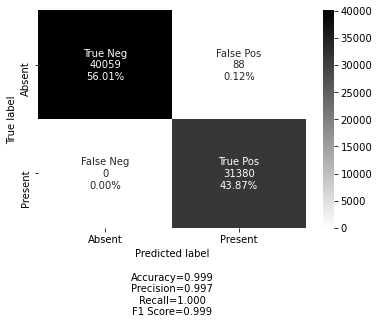

In [168]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Absent', 'Present']
make_confusion_matrix(cf_m,
                      group_names=labels,
                      categories=categories,
                      cmap='binary')

print('True Postive Rate: {}'.format(cf_m[1][1]/(cf_m[1][0] + cf_m[1][1])))
print('False Postive Rate: {}'.format(cf_m[0][1]/(cf_m[0][0] + cf_m[0][1])))

### Test Results

In [169]:
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.map(get_val)
val_dataset = val_dataset.batch(64, drop_remainder=False)

In [170]:
y_pred = model.predict(val_dataset)
y_pred

array([[0.0438268 ],
       [0.05248588],
       [0.04998931],
       ...,
       [0.05001183],
       [0.04517113],
       [0.04043977]], dtype=float32)

In [174]:
svt_true = y_val.T[0]
svt_pred = y_pred.T[0]

svt_pred = np.around(svt_pred).astype(np.int)

In [175]:
cf_m = confusion_matrix(svt_true, svt_pred)
cf_m

array([[9980,   62],
       [  14,  112]])

True Postive Rate: 0.8888888888888888
False Postive Rate: 0.006174068910575582


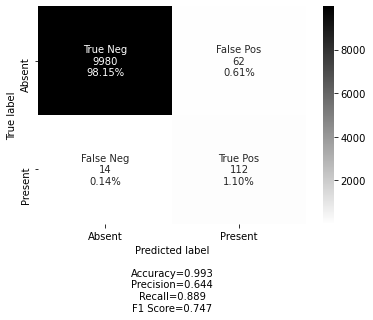

In [176]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Absent', 'Present']
make_confusion_matrix(cf_m,
                      group_names=labels,
                      categories=categories, 
                      cmap='binary')

print('True Postive Rate: {}'.format(cf_m[1][1]/(cf_m[1][0] + cf_m[1][1])))
print('False Postive Rate: {}'.format(cf_m[0][1]/(cf_m[0][0] + cf_m[0][1])))

## Save and Load Model

In [177]:
model.save('svt_model.h5')
loaded_model = tf.keras.models.load_model('svt_model.h5')